In [12]:
%load_ext autoreload
%autoreload 2

# --- Cell 1: Imports ---
import numpy as np
import numpy_financial as npf # Although functions are in mortgage_mc, good practice
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time # To time the simulation


from mortgage_mc import get_base_config, run_monte_carlo_simulation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# --- Cell 2: Define Simulation Parameters & Distribution Assumptions ---

NUM_SIMULATIONS = 10000  # Number of Monte Carlo runs (e.g., 10k, 50k. More = smoother distributions but longer run time)
base_config = get_base_config() # Get base settings from the module

# --- !!! CRITICAL: Define YOUR Assumptions for the Distributions !!! ---
# These mean (average) and std dev (volatility/uncertainty) values are the core
# assumptions driving the Monte Carlo results. Adjust them carefully!
distribution_assumptions = {
    "prop_app_mean": 0.03,      # Average expected property appreciation per year (e.g., 3%)
    "prop_app_std_dev": 0.05,   # Volatility of property appreciation (e.g., 5% std dev)
    "alt_inv_mean": 0.05,       # Average expected NET return on alternative investments per year (e.g., 5%)
    "alt_inv_std_dev": 0.08,   # Volatility of alternative investment returns (e.g., 8% std dev)
    "sc_inf_mean": 0.035,       # Average expected service charge inflation per year (e.g., 3.5%)
    "sc_inf_std_dev": 0.025  # Volatility of service charge inflation (e.g., 2.5% std dev)
}

In [14]:
# --- Cell 2: Define Simulation Parameters & Distribution Assumptions ---
NUM_SIMULATIONS = 10000  # Number of Monte Carlo runs (e.g., 10k, 50k. More = smoother distributions but longer run time)
base_config = get_base_config() # Get base settings from the module

# --- Define Assumptions for the Distributions !!! ---
# These mean (average) and std dev (volatility/uncertainty) values are the core
# assumptions driving the Monte Carlo results. Adjust them carefully!
distribution_assumptions = {
    "prop_app_mean": 0.03,      # Average expected property appreciation per year (e.g., 3%)
    "prop_app_std_dev": 0.05,   # Volatility of property appreciation (e.g., 5% std dev)
    "alt_inv_mean": 0.05,       # Average expected NET return on alternative investments per year (e.g., 5%)
    "alt_inv_std_dev": 0.08,   # Volatility of alternative investment returns (e.g., 8% std dev)
    "sc_inf_mean": 0.035,       # Average expected service charge inflation per year (e.g., 3.5%)
    "sc_inf_std_dev": 0.025  # Volatility of service charge inflation (e.g., 2.5% std dev)
}

print("--- Monte Carlo Simulation Setup ---")
print(f"Number of simulations: {NUM_SIMULATIONS:,}")
print("\nDistribution Assumptions (Mean / Std Dev):")
print(f"  Property Apprec.:    {distribution_assumptions['prop_app_mean']:.1%} / {distribution_assumptions['prop_app_std_dev']:.1%}")
print(f"  Alt. Investment Ret.: {distribution_assumptions['alt_inv_mean']:.1%} / {distribution_assumptions['alt_inv_std_dev']:.1%}")
print(f"  Service Chg Infl.:   {distribution_assumptions['sc_inf_mean']:.1%} / {distribution_assumptions['sc_inf_std_dev']:.1%}")
print(f"\nKey Fixed Params (from base config):")
print(f"  Initial Property Value: £{base_config['property_value_initial']:,.0f}")
print(f"  Holding Period:       {base_config['holding_period_years']} years")
print(f"  Mortgage Rate (Fixed): {base_config['mortgage_interest_rate_annual']:.2%}")
print(f"  Deposit Percentage:   {base_config['deposit_percentage']:.0%}")
print(f"  Initial Service Charge: £{base_config['service_charge_annual_initial']:,.0f} p.a.")
print(f"  Other Buying Costs %: {base_config['buying_costs_percentage_other']:.1%}")
print(f"  Selling Costs %:      {base_config['selling_costs_percentage']:.1%}")


--- Monte Carlo Simulation Setup ---
Number of simulations: 10,000

Distribution Assumptions (Mean / Std Dev):
  Property Apprec.:    3.0% / 5.0%
  Alt. Investment Ret.: 5.0% / 8.0%
  Service Chg Infl.:   3.5% / 2.5%

Key Fixed Params (from base config):
  Initial Property Value: £575,000
  Holding Period:       10 years
  Mortgage Rate (Fixed): 4.50%
  Deposit Percentage:   20%
  Initial Service Charge: £6,500 p.a.
  Other Buying Costs %: 1.5%
  Selling Costs %:      2.0%


In [15]:
# --- Cell 3: Run the Monte Carlo Simulation ---
print(f"\n--- Running {NUM_SIMULATIONS:,} Simulations (This may take a moment...) ---")
start_time = time.time()

# Ensure the functions were imported before running
if 'run_monte_carlo_simulation' in globals():
    cash_mc_results, mortgage_mc_results = run_monte_carlo_simulation(
        base_config=base_config,
        num_simulations=NUM_SIMULATIONS,
        **distribution_assumptions # Pass the distribution parameters
    )
    end_time = time.time()
    print(f"\n--- Simulation Complete ---")
    print(f"Duration: {end_time - start_time:.2f} seconds")
    print(f"Generated {len(cash_mc_results)} cash scenario results.")
    print(f"Generated {len(mortgage_mc_results)} mortgage scenario results.")
else:
    print("ERROR: Simulation function not loaded. Cannot run.")
    cash_mc_results, mortgage_mc_results = [], [] # Assign empty lists


--- Running 10,000 Simulations (This may take a moment...) ---
  Completed simulation 1000/10000
  Completed simulation 2000/10000
  Completed simulation 3000/10000
  Completed simulation 4000/10000
  Completed simulation 5000/10000
  Completed simulation 6000/10000
  Completed simulation 7000/10000
  Completed simulation 8000/10000
  Completed simulation 9000/10000
  Completed simulation 10000/10000

--- Simulation Complete ---
Duration: 3.96 seconds
Generated 10000 cash scenario results.
Generated 10000 mortgage scenario results.


In [16]:
# --- Cell 4: Process and Analyze Results ---

# Define helper functions to extract metrics (can also be put in mortgage_mc.py)
def calculate_net_gain(results):
     # Definition: Final Assets - Initial Outlay - All Running Costs (incl. interest)
     if not results: return np.nan # Handle potential empty results
     net_gain = (
        results.get('final_equity_in_property', 0) +
        results.get('value_of_alternative_investments_at_end', 0) -
        results.get('initial_cash_outlay', 0) -
        results.get('total_ongoing_property_costs_paid', 0) -
        (results.get('total_mortgage_interest_paid', 0) if not results.get('is_cash_purchase', True) else 0)
    )
     return net_gain

def calculate_roi(results, holding_period):
    # Definition: Annualized return on initial cash outlay
    if not results: return np.nan
    net_gain = calculate_net_gain(results)
    initial_outlay = results.get('initial_cash_outlay', 0)
    if initial_outlay <= 0 or holding_period <= 0: return np.nan

    ending_value = initial_outlay + net_gain
    # Prevent issues with negative ending values for exponentiation
    if ending_value <= 0: return -1.0 # Represent total loss or worse as -100%

    # Calculate CAGR
    base = ending_value / initial_outlay
    # Handle potential complex numbers if base is negative (though checked above)
    if isinstance(base, complex): return np.nan # Or handle appropriately
    # Handle base being zero or negative which is now caught by ending_value <= 0 check
    
    try:
      # Use np.real to handle potential tiny imaginary parts due to floating point issues if base is negative
      # but the previous check should prevent this.
      roi = (base ** (1/holding_period)) - 1
    except ValueError: # Handles potential issues if base is negative after all checks
        roi = -1.0 
        
    return roi


# Extract metrics into NumPy arrays
if cash_mc_results and mortgage_mc_results: # Proceed only if simulations ran
    cash_net_gains = np.array([calculate_net_gain(res) for res in cash_mc_results])
    mortgage_net_gains = np.array([calculate_net_gain(res) for res in mortgage_mc_results])

    holding_period = base_config['holding_period_years']
    cash_rois = np.array([calculate_roi(res, holding_period) for res in cash_mc_results])
    mortgage_rois = np.array([calculate_roi(res, holding_period) for res in mortgage_mc_results])

    # Clean potential NaNs from arrays if any issues occurred (though less likely now)
    cash_net_gains = cash_net_gains[~np.isnan(cash_net_gains)]
    mortgage_net_gains = mortgage_net_gains[~np.isnan(mortgage_net_gains)]
    cash_rois = cash_rois[~np.isnan(cash_rois)]
    mortgage_rois = mortgage_rois[~np.isnan(mortgage_rois)]
    
    processing_successful = True
else:
    processing_successful = False
    print("ERROR: No simulation results to process.")

In [17]:
# --- Cell 5: Display Summary Statistics ---
if processing_successful:
    print("\n--- Monte Carlo Results Summary (Based on Random Variables) ---")

    scenarios_mc = {
        "Cash": {"net_gains": cash_net_gains, "rois": cash_rois},
        "Mortgage": {"net_gains": mortgage_net_gains, "rois": mortgage_rois}
    }

    for name, data in scenarios_mc.items():
        print(f"\n--- {name} Scenario ---")
        if len(data['net_gains']) > 0:
            print(f"  Net Gain:")
            print(f"    Mean:      £{np.mean(data['net_gains']):,.0f}")
            print(f"    Median:    £{np.median(data['net_gains']):,.0f}") # Median less affected by outliers
            print(f"    Std Dev:   £{np.std(data['net_gains']):,.0f}")    # Measure of risk/spread
            print(f"    Min:       £{np.min(data['net_gains']):,.0f}")
            print(f"    Max:       £{np.max(data['net_gains']):,.0f}")
            print(f"    5th Pctl:  £{np.percentile(data['net_gains'], 5):,.0f}") # Likely lower bound outcome
            print(f"    95th Pctl: £{np.percentile(data['net_gains'], 95):,.0f}") # Likely upper bound outcome

            print(f"  Annualized ROI:")
            print(f"    Mean:      {np.mean(data['rois']):.2%}")
            print(f"    Median:    {np.median(data['rois']):.2%}")
            print(f"    Std Dev:   {np.std(data['rois']):.2%}")
            print(f"    Min:       {np.min(data['rois']):.2%}")
            print(f"    Max:       {np.max(data['rois']):.2%}")
            print(f"    5th Pctl:  {np.percentile(data['rois'], 5):.2%}")
            print(f"    95th Pctl: {np.percentile(data['rois'], 95):.2%}")
        else:
             print("    No valid results to summarize.")

    # --- Cell 6: Probability Analysis ---

    if processing_successful and len(cash_net_gains) > 0 and len(mortgage_net_gains) > 0:
        min_len = min(len(mortgage_net_gains), len(cash_net_gains))
        mortgage_outperforms_net_gain = np.sum(mortgage_net_gains[:min_len] > cash_net_gains[:min_len]) / min_len

        min_len_roi = min(len(mortgage_rois), len(cash_rois))
        mortgage_outperforms_roi = np.sum(mortgage_rois[:min_len_roi] > cash_rois[:min_len_roi]) / min_len_roi

        print("\n--- Probability Analysis ---")
        print(f"Probability Mortgage outperforms Cash (Net Gain): {mortgage_outperforms_net_gain:.1%}")
        print(f"Probability Mortgage outperforms Cash (Annualized ROI): {mortgage_outperforms_roi:.1%}")
    else:
        print("\n--- Probability Analysis ---")
        print("    Not enough data for comparison.")



--- Monte Carlo Results Summary (Based on Random Variables) ---

--- Cash Scenario ---
  Net Gain:
    Mean:      £45,511
    Median:    £37,709
    Std Dev:   £115,930
    Min:       £-286,028
    Max:       £564,104
    5th Pctl:  £-130,788
    95th Pctl: £247,578
  Annualized ROI:
    Mean:      0.59%
    Median:    0.61%
    Std Dev:   1.81%
    Min:       -6.24%
    Max:       6.83%
    5th Pctl:  -2.42%
    95th Pctl: 3.50%

--- Mortgage Scenario ---
  Net Gain:
    Mean:      £735,644
    Median:    £720,543
    Std Dev:   £217,851
    Min:       £76,928
    Max:       £1,908,000
    5th Pctl:  £405,450
    95th Pctl: £1,121,527
  Annualized ROI:
    Mean:      19.51%
    Median:    19.64%
    Std Dev:   3.02%
    Min:       4.38%
    Max:       30.44%
    5th Pctl:  14.34%
    95th Pctl: 24.29%

--- Probability Analysis ---
Probability Mortgage outperforms Cash (Net Gain): 100.0%
Probability Mortgage outperforms Cash (Annualized ROI): 100.0%



--- Generating Plots ---


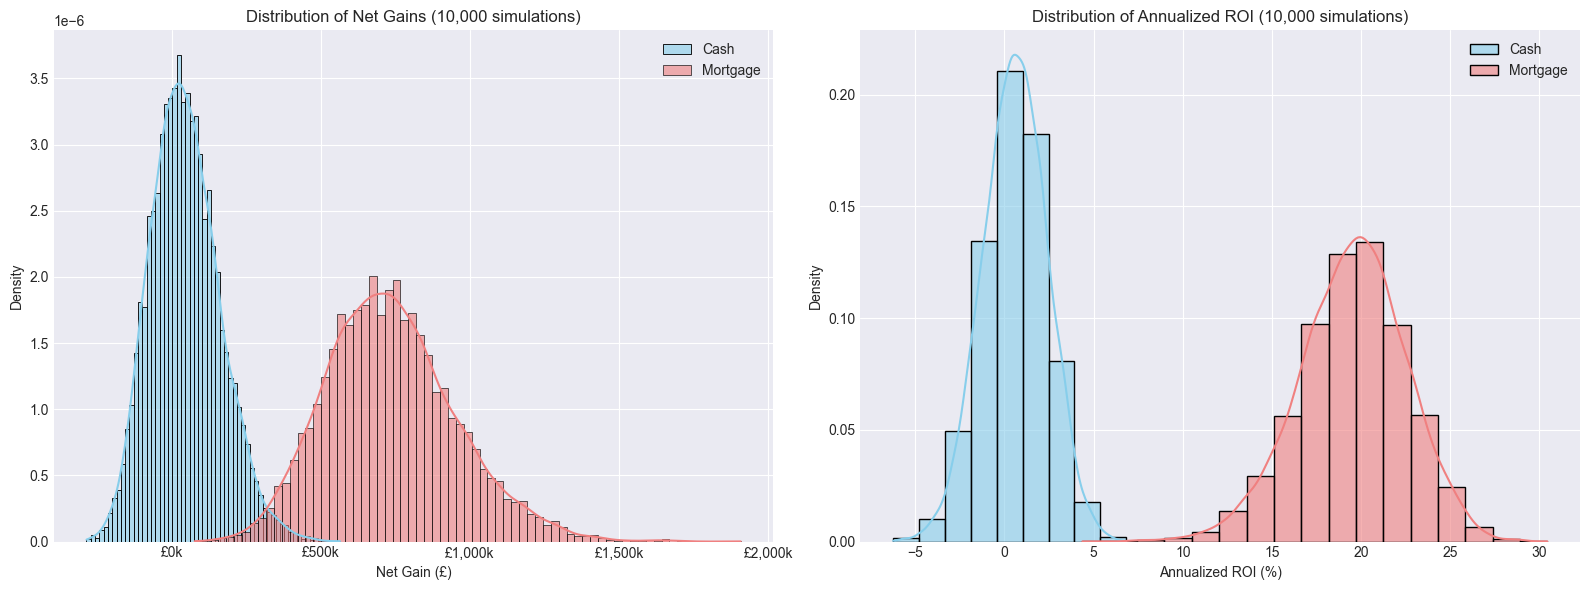

In [18]:
# --- Cell 7: Plotting Distributions ---

if processing_successful and len(cash_net_gains) > 0 and len(mortgage_net_gains) > 0:
    print("\n--- Generating Plots ---")
    # Optional: Use pandas DataFrame for easier handling with seaborn
    df_results = pd.DataFrame({
        'Cash Net Gain': cash_net_gains,
        'Mortgage Net Gain': mortgage_net_gains,
        'Cash ROI (%)': cash_rois * 100,
        'Mortgage ROI (%)': mortgage_rois * 100
    })

    plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style
    fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # Increased figure size

    # Net Gain Histogram & KDE
    sns.histplot(data=df_results, x='Cash Net Gain', kde=True, ax=axes[0], label='Cash', color='skyblue', stat='density', alpha=0.6)
    sns.histplot(data=df_results, x='Mortgage Net Gain', kde=True, ax=axes[0], label='Mortgage', color='lightcoral', stat='density', alpha=0.6)
    axes[0].set_title(f'Distribution of Net Gains ({NUM_SIMULATIONS:,} simulations)')
    axes[0].set_xlabel('Net Gain (£)')
    axes[0].legend()
    # Improve x-axis formatting for currency
    from matplotlib.ticker import FuncFormatter
    axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'£{x/1000:,.0f}k')) # Format as £Xk

    # Annualized ROI Histogram & KDE
    sns.histplot(data=df_results, x='Cash ROI (%)', kde=True, ax=axes[1], label='Cash', color='skyblue', stat='density', alpha=0.6, binwidth=1.5) # Adjust binwidth if needed
    sns.histplot(data=df_results, x='Mortgage ROI (%)', kde=True, ax=axes[1], label='Mortgage', color='lightcoral', stat='density', alpha=0.6, binwidth=1.5) # Adjust binwidth
    axes[1].set_title(f'Distribution of Annualized ROI ({NUM_SIMULATIONS:,} simulations)')
    axes[1].set_xlabel('Annualized ROI (%)')
    axes[1].legend()


    plt.tight_layout()
    plt.show()
else:
    print("\n--- Plots Skipped (No results) ---")